<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Расчёты-и-добавление-результатов-в-таблицу" data-toc-modified-id="Расчёты-и-добавление-результатов-в-таблицу-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расчёты и добавление результатов в таблицу</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pymystem3 import Mystem

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [ ]:
# чтение файла
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')

#получение общей информации о дынных
df.info()

**Вывод** : после первичного изучения датасета, в данных найдены пропуски, разница в типе данных, неоднородность данных. Все это может помешать анализу данных и подлежит обработке.

1. В файле csv данные были разделены знаком табуляции \t, а десятичные значения разделены точкой, и без уточнения этого в методе read_csv, файл становится нечитаемым.
2. Макс. число исследуемых данных - 23699, число столбцов - 22. Пропущенные значения обнаружены в во всех столбцах, кроме: 'total_images','last_price','total_area','first_day_exposition', 'rooms', 'studio', и 'open_plan'. Типы объектов до обработки данных: bool, int64, objectб float64. 
3. В столбце locality_name проспуски необходимо заполнить или удалить.
4. столбец 'is_apartment' обозначен как тип object, хотя это булевое значение. необходимо заменить тип данных и заполнить пропуски.
4. столбец 'first_day_exposition' нужно привести к типу данных datetime
5. типы float заменить на int для удобства и наглядности

## Предобработка данных

In [2]:
#Замена значений и запонение пропусков по-порядку
#  1
df[['balcony', 'parks_around3000', 
    'ponds_around3000', 'parks_nearest','ponds_nearest']] = df[['balcony','parks_around3000',
                                                                'ponds_around3000','parks_nearest','ponds_nearest']].fillna(0)
df[['ceiling_height',
    'floors_total',
    'airports_nearest',
    'cityCenters_nearest']] = df[['ceiling_height',
                              'floors_total',
                              'airports_nearest',
                              'cityCenters_nearest']].fillna(df[['ceiling_height','floors_total',
                                                             'airports_nearest','cityCenters_nearest']].median())

df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].max()) #основываясь на предположении, что объявление еще выставлено

In [3]:
#  2
df['living_area'] = df.groupby('rooms')['living_area'].apply(lambda x: x.fillna(x.median()))
df['kitchen_area'] = df.groupby('rooms')['kitchen_area'].apply(lambda x: x.fillna(x.median()))
df['kitchen_area'] = df['kitchen_area'].fillna(0) #для значений, которые не вошли ни в одну катег.

#  3
print(df['is_apartment'].value_counts()) #Проверка на наличие/отсутствие определенных булевых значений
df['is_apartment'] = df['is_apartment'].fillna('True')
print()

#  4 
df['locality_name'] = df['locality_name'].fillna('Неизвестно')

#df.info()
#df.head()

False    2725
True       50
Name: is_apartment, dtype: int64



/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [4]:
#Замена типов данных
df = df.astype({'last_price':'int','total_area':'int', 'ceiling_height':'int', 'floors_total':'int', 'living_area':'int',
                'kitchen_area':'int', 'balcony':'int', 'airports_nearest':'int', 'cityCenters_nearest':'int',
                'parks_around3000':'int', 'parks_nearest':'int', 'ponds_around3000':'int',
                'ponds_nearest':'int', 'days_exposition':'int'})

df['is_apartment'] = df['is_apartment'].astype('bool')

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

df['locality_name'] = df['locality_name'].str.lower()

In [5]:
#Лемматизация

m = Mystem()

lemmas = m.lemmatize(' '.join(df['locality_name']))

exceptions = ['\n', 'посёлок', 'поселок', 'село', 'город', 'городской', 'деревня', 'бор', 'луг','городского', 'типа']

def lemmatize_col(row):
    for word in m.lemmatize(row):
        if word in list(set(lemmas)) and (word not in exceptions):
            return word  
        if word in exceptions:
            return ''.join(row.split(' ', 1)[1:]).lower()
        
#Применение функции к столбцу в датафрейме
df['lemmatized_locality'] = df['locality_name'].apply(lemmatize_col)


#print(df['lemmatized_locality'].unique())
#df.info()

**Вывод** : После замены и заполнения пропущенных значений, датафрейм был приведен к единому стандарту, с чем будет удобнее работать в последующих заданиях. 

P.S.:Замена пропусков не требовалась во всех столбцах, но мне нравится, когда датафрейм выглядит организованно, и так как есть возможность и столбцов не слишком много, я решила заполнить все пропуски.

*Возможные причины появления пропусков*: чаще всего причиной является человеческий фактор. В данном случае, это может быть сокрытие какой-либо информации. Другой возмодной причиной могут быть ошибки ввода данных или отсутствие таких данных (Например, программа не смогла рассчитать расстояние кв. до аэропорта, потому что в данном населенном пункте нет аэропорта или он не обозначен).

Что было сделано в ходе "Шага 2":
1. Заполнеие попусков в датафрейме. В шаге #1 после анализа данных было обнаружено, что все пропущенные значения в столбцах 'balcony', 'parks_around3000', 'ponds_around3000', 'parks_nearest', и 'ponds_nearest' можно заменить 0, основываясь на предположении, что если эти значения не указаны, зачит они отсутствуют. Затем, в стобцах 'ceiling_height','floors_total','airports_nearest', и 'cityCenters_nearest' подставлена медиана во всех пропузенных значениях. Медиану выбрана потому, что в данных столбцах может быть большая разница между минимальным и максимальным значениями и распеределение может быть не равномерно. Альтернативой могло быть mean, но после проверки было выявлено, что mean & median в этих столбцах примерно одинаковы, поэтому проблем с данными нет. 'days_exposition' было заполнено максимальным значением (в днях) в столбце, предположив, что пропуски в значениях означают, что жилье все еще выставлено на продажу, и что день анализа данных равен макс. значению.

2. В шаге #2 пропуски в столбцах 'kitchen area' & 'living area' обработаны, опираясь на логику, что рамер жилой площади и кухни очень зависит от размера апартаментов/здания, который можно определить по номеру комнат ('rooms') на основе из имеющихся данных, были сгруппированы каждый из столбцов по номеру комнат(=размеру помещения) и заполнены пропуски медианой по группам. Как и в прошлом случае, медиана была выбрана потому что в данных имеется большая разница между мин и макс значениями, а также неравномерный разброс. 

3. В шагах #3 и #4 обрабатан столбец с булевыми значениями 'is_apartment' и пропуски в 'locality_name'. Проверив наличие кол-ва True & False statements в столбце, был сделан вывод, что так как True слишком мало в соотношении с false, возможно, что все пропущенные значения в столбце по умолчанию - True. Проверить достоверность этому можно только при более детальном анализе отдельных адресов. В случае с 'locality_name', все неизвестные адреса были заменены на "Неизвестно".

4. Далее - замена типов данных. Как было уже упомянуто в "Шаге 1", типы данных в столбцах неоднородные + были обнаружены infinite значения (число, стремящееся к бесконечности) там, где их не должно быть (например, расстояние до аэропорта) + в дальнейшем нам для анализа необходимо будет проводить вычисления, поэтому тип объекта float64 не удобен для расчетов. По этим причинам, все столбцы типа float64 я привела к типу int64; столбец 'first_day_exposition' содержащий дату выставления объявления был приведен к соответствующему типу datetime64; и наконец, 'is_apartment' был приведен к надлежащему ему типу bool.

5. Последним шагом было исправить неоднородность в данных с названиями населенных пунктов (напр., поселок записан еще и как "посёлок"), а также обеспечить простоту поиска по данным в случае необходимости. Поэтому, сперва все значения в столбце были приведены к единому нижнему регистру, а затем, с помощью библиотеки mystem, вручную собранного словаря 'exceptions' по словам из set(lemmas) и функции, создан новый столбец 'lemmatized_locality'. Теперь поиск по данным стал немного проще.


## Расчёты и добавление результатов в таблицу

In [6]:
#Цена кв. метра
df['price_sq_m'] = (df['last_price']/df['total_area']).astype('int')

#День недели, месяц и год публикации объявления
df['publication_day'] = pd.DatetimeIndex(df['first_day_exposition']).day
df['publication_month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['publication_year'] = pd.DatetimeIndex(df['first_day_exposition']).year

#этаж квартиры; варианты — первый, последний, другой
df['floors_type'] = df.apply(lambda row: 'первый' if row['floor']== 1 else ('последний' if row['floor'] == row['floors_total'] else 'другой'),axis=1)

#соотношение жилой и общей площади, а также отношение площади кухни к общей
df['living2total_ratio'] = (df['living_area']/df['total_area']).round(2)
df['kitchen2total_ratio'] = (df['kitchen_area']/df['total_area']).round(2)

#last_price в 1000 000
df['last_price_in_mln'] = df['last_price']/1000000

df.head() #- проверка 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,lemmatized_locality,price_sq_m,publication_day,publication_month,publication_year,floors_type,living2total_ratio,kitchen2total_ratio,last_price_in_mln
0,20,13000000,108,2019-03-07,3,2,16,51,8,True,...,1580,санкт-петербург,120370,7,3,2019,другой,0.47,0.23,13.000
1,7,3350000,40,2018-12-04,1,2,11,18,1,True,...,81,шушары,83750,4,12,2018,первый,0.45,0.28,3.350
2,10,5196000,56,2015-08-20,2,2,5,34,4,True,...,558,санкт-петербург,92785,20,8,2015,другой,0.61,0.14,5.196
3,0,64900000,159,2015-07-24,3,2,14,45,9,True,...,424,санкт-петербург,408176,24,7,2015,другой,0.28,0.06,64.900
4,2,10000000,100,2018-06-19,2,3,14,32,13,True,...,121,санкт-петербург,100000,19,6,2018,другой,0.32,0.41,10.000


**Вывод** : проведены расчеты по цене кв. метра, соотношению жилой плозади и площади кухни к общей, а также добавлены в табоицу день, месяц и год публикации, а также описаны типы этажей в квартире, так как это может сильно влиять на цену. эти данные пригодятся для построения графиков и статистики в следующем шаге.

1. расчеты цена квартиры на кв. метр просты: поделить последнюю указанную цену на кв. метр в исследуемой жилой площади. результат переведен в тип данных 'int' для удобства и наглядности.
2. создан отдельный столбец для каждой из итераций для удобства исследования, но возможно при построении статистики в след. шаге потребуется это откорректировать
3. сначала я выполнила этот код через функцию def и отдельно apply (функция работала корректно), но в моем случае она работала только с копированием данных, и мне хотелось ее усовершенствовать, поэтому я выполнила ее через анонимную функцию lambda. *Изначальный вариант функции ниже*:

In [7]:
%%script echo skipping
def type_separator(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
df['floo_type'] = df.apply(type_separator, axis=1)
print(df['floo_type'])

skipping


4. при подсчете соотношений жилой площади к общей площади и площади кухни к общей, данные были округлены до сотой для удобства.
5. Так как цены на квартиры очень велики, я создала дополнительный столбец, где поделила цену каждой квартиры на 1 000 000, чтобы она была указана в миллионах

## Исследовательский анализ данных

         total_area  last_price_in_mln         rooms  ceiling_height
count  23699.000000       23699.000000  23699.000000    23699.000000
mean      60.120511           6.541549      2.070636        2.142411
std       35.665822          10.887013      1.078405        1.033337
min       12.000000           0.012190      0.000000        1.000000
25%       40.000000           3.400000      1.000000        2.000000
50%       52.000000           4.650000      2.000000        2.000000
75%       69.000000           6.800000      3.000000        2.000000
max      900.000000         763.000000     19.000000      100.000000


Text(0.5, 1.0, 'Гистограмма распределенния данных о площади продаваемого помещения')

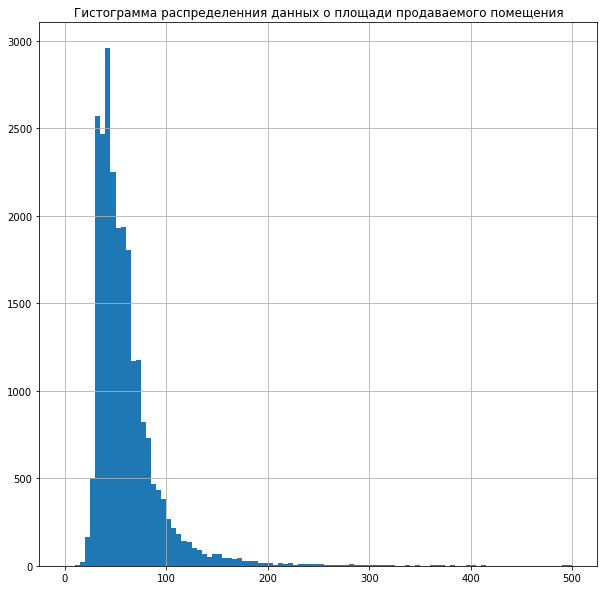

In [8]:
#Гистограмма по площади

print(df[['total_area','last_price_in_mln','rooms','ceiling_height']].describe())


df['total_area'].hist(bins=100, range=(0,500), figsize=(10,10), grid=True)
plt.title('Гистограмма распределенния данных о площади продаваемого помещения')

Данная гистограмма показвает, что большая часть выставленных на продажу жилых помещеним имеют площадь от 30 до 100 кв. м.

Text(0.5, 1.0, 'Распределение данных о цене жилых помещений в млн. руб.')

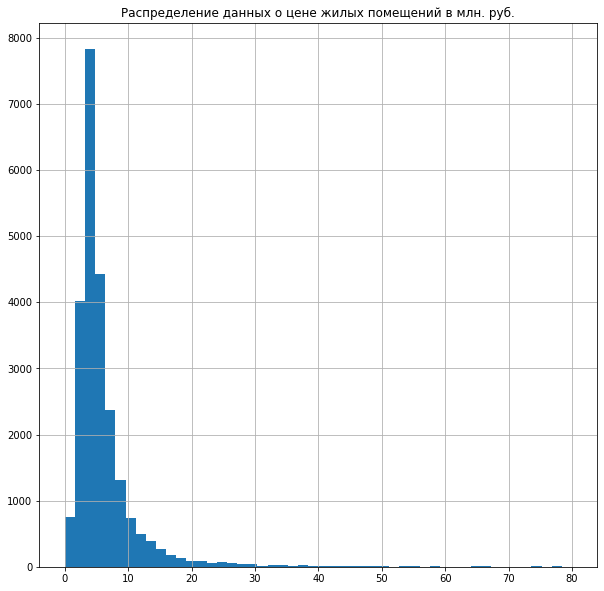

In [9]:
#print(df['last_price'].min(),df['last_price'].max())

df['last_price_in_mln'].hist(bins=50, range=(0,80), figsize=(10,10), grid=True)
plt.title('Распределение данных о цене жилых помещений в млн. руб.')

Данная гистограмма показвает, что большая часть выставленных на продажу жилых помещений имеют цены от 2 до 20 млн. руб.

Text(0.5, 1.0, 'Распределение данных о кол-ве комнат в продаваемых помещениях')

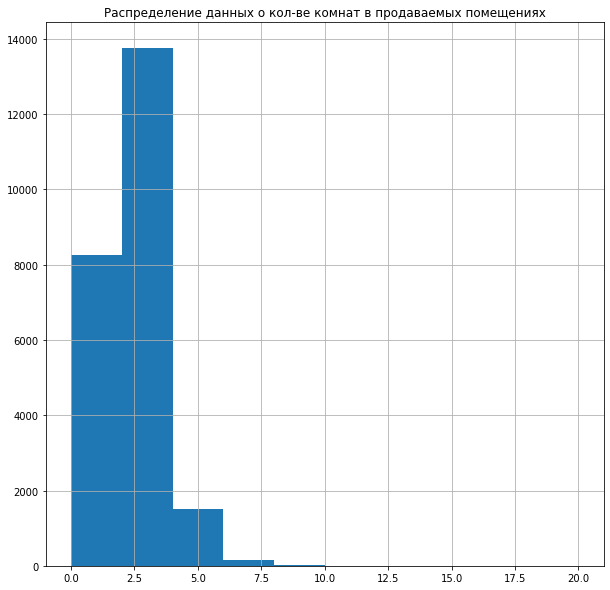

In [10]:
df['rooms'].hist(bins=10, range=(0,20), figsize=(10,10), grid=True)
plt.title('Распределение данных о кол-ве комнат в продаваемых помещениях')

Данная гистограмма показвает, что большинство помещений в датасете имеют от 0 до 5 комнат.

Text(0.5, 1.0, 'Распределение данных о высоте потолков продаваемых помещений')

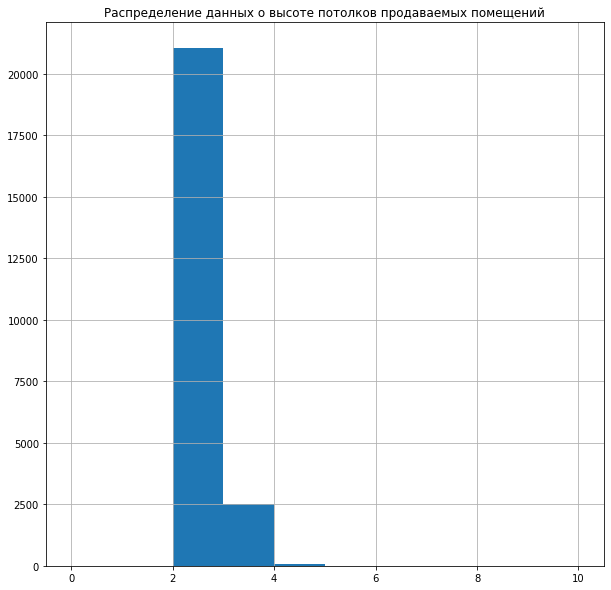

In [11]:
df['ceiling_height'].hist(bins=10, range=(0,10), figsize=(10,10), grid=True)
plt.title('Распределение данных о высоте потолков продаваемых помещений')

Данная гистограмма показвает, что большинство помещений в датасете имеют высоту потолков от 2 до 4 метров.

**Вывод 4.1** : Изучив параметры площади, цены, числа комнат и высоты потолков и осмотрев их гистограммы, можно сделать вывод, что в каждом из параметров есть большое количество данных сосредоточенных на минимальных значениях, близких к нулю, а ближе к максимуму из почти уже нет. В 'total_area' я указала range до 500, потому что, хоть макс. значение и 900, после 500 их уже слишком мало, поэтому они скорее мешают для оценки общей картины. Тем не менее, большинство этих гистограм по распределению напоминают распределение Пуассона.

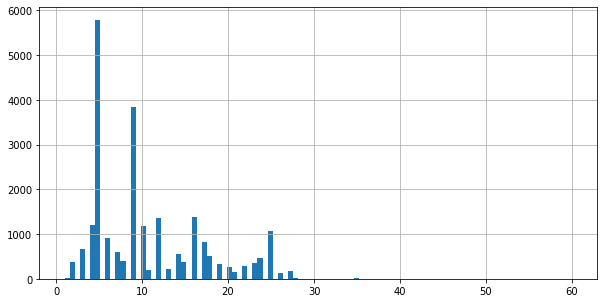

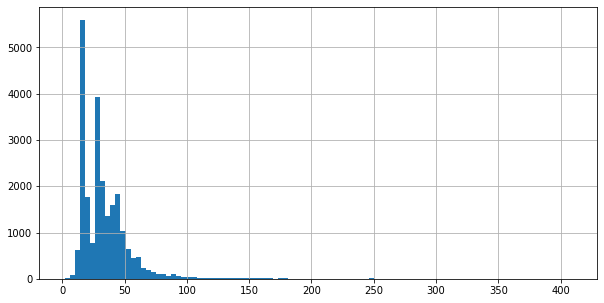

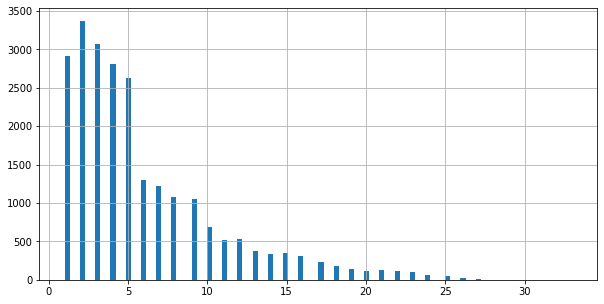

In [27]:
cols = ['floors_total', 'living_area', 'floor']
for i in cols:
    df[i].hist(bins=100, figsize=(10,5), grid=True)
    plt.show()

count    23699.000000
mean       368.684459
std        518.930898
min          1.000000
25%         45.000000
50%        124.000000
75%        390.000000
max       1580.000000
Name: days_exposition, dtype: float64

В среднем жилье продается за 368.68 дней
Медианное число дней, чтобы продать жилье - 124.0 дней



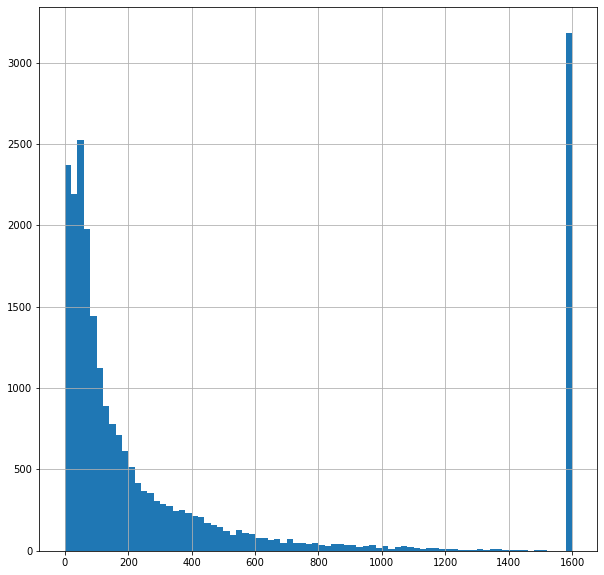

In [13]:
#Изучение времени продажи кв.
print(df['days_exposition'].describe())
mean = (df['days_exposition'].mean()).round(2)
median = (df['days_exposition'].median()).round(2)
print()
print("В среднем жилье продается за {} дней".format(mean))
print("Медианное число дней, чтобы продать жилье - {} дней".format(median))
print()
df['days_exposition'].hist(bins=80, range=(0,1600), figsize=(10,10), grid=True)

**Вывод 4.2** : Благодаря методу describe, можно сделать след. выводы: 
1) Макс. кол-во дней выставления объявления - 1580, но гистограмма показывает, что только 25% всех данных больше 390. 

2) У гистограммы в целом довольно большая концентрация данных в от 0 до 100 дней, затем увеличение кол-ва дней для продажи квартиры уменьшается в числе, и наконец виден выброс на 1580. Этот выброс легко объяснить тем, что при заполнении пропусков я руководствовалась логикой, что отсутствующие значения означают, что квартира все еще выставленна на продажу. Так как природа пропусков неизвестна, а также это менее 10% всех данных в столбце, я не стану учитывать числа 1580. 

3) По гистограмме также видно, что после 800 в целом очень мало значений, поэтому все значения выше 1000 это уже необычно долгие значения.Если считать, что в году 365 дней, то 1000 дней будет 2.7 года, а 800 дней - 2.1. При этом, % концентрирования данных после 800 и 1000 не очень отличается. Это довольно необычно долгое время для продажи квартиры. Возможно с ней или с ее документами какие-то проблемы. В дальнейшем я установила верхний лимит для анализа данных чуть больше 2х лет, то есть 800 дней

4) Соответственно, квартиры проданные за 1 день (минимальное значение) это необычно быстро. Возможно, сделка о продаже квартиры была заключена заранее или же покупателю было не важно, какую квартиру они покупают. Значения ниже 45 дней занимают только 25% всех данных.

count    19924.000000
mean       155.848474
std        164.903461
min          1.000000
25%         44.000000
50%         91.000000
75%        212.000000
max        799.000000
Name: days_exposition, dtype: float64


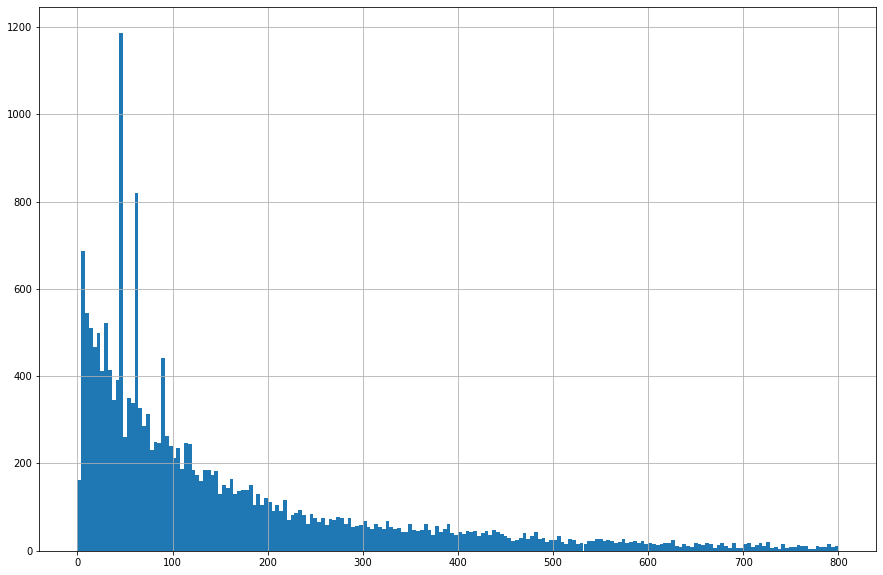

In [14]:
#Удаление редких и выбивающихся значений
good_data = df.query('days_exposition < 800')
print(good_data['days_exposition'].describe())
good_data['days_exposition'].hist(bins=200, range=(0,800), figsize=(15,10), grid=True)

**Вывод 4.3** : Можно сделать след. выводы: 

После выполнения среза данных и убирания всех выбивающихся значений, теперь все распределения на гистограмме видны более четко. Самое крупное воличество значения находятся в области примерно между 30 и 200 днями, что является нормальным временем для продажи жилья. Резкий выброс в кол-ве дней на продажу квартиры находится в области около 50 дней. Все значения выше и ниже - редкие случаи.

                     price_sq_m  cityCenters_nearest
price_sq_m             1.000000            -0.252441
cityCenters_nearest   -0.252441             1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa609bc59d0>,
      dtype=object)

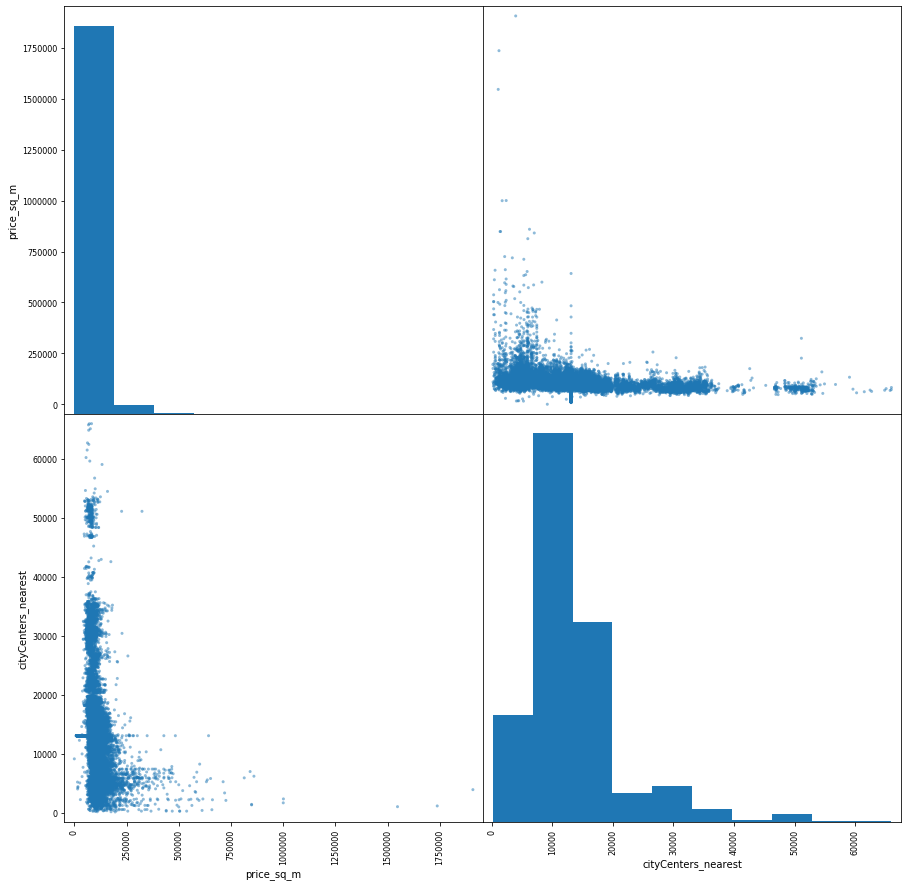

In [15]:
#зависит ли цена от площади, числа комнат, удалённости от центра.
price_RoomAreaCenter = df[['price_sq_m','total_area', 'rooms','cityCenters_nearest']]
print(price_RoomAreaCenter.corr()) #Корреляция между переменными в матрице

pd.plotting.scatter_matrix(price_RoomAreaCenter, figsize=(15, 15)) 

**Вывод 4.4** : Можно сделать след. выводы: 

В данной матрице диаграмм рассеяния нам главным образом нужно обратить внимание на 1й столбец (крайний слева). 
1) Зависимость цены от площади помещения и кол-ва комнат: цена к отношению площади и кол-ва комнат распределена неравномерно. Чаще всего такой разброс данных означает недостаточнойсть или сильную неоднородность данных в таблице (возможно - ошибки в данных). Тем не менее, по гистограммам можно увидеть, что чем меньше площадь и меньше кол-во комнат, тем ниже цена - вне зависимости от регионов.

2) Гистограмма зависимости цены от удаленности помещения от центра показывает, что цена может быть относительно низкой и при довльно большом расстоянии от центра. Однако в данном случае мы исследуем все регионы вместе, что очень сильно может исказить реальную картину статистики. Ниже мы рассмотрим ту же зависимость по конкретному местоположению  - Санкт-Петербургу.

3) Из таблицы корреляции переменных видно (опять же, нам наиболее интересен крайний левый стобец), что цена, кол-во комнат, площидт имеют позитивную, но слабую корреляцию. Позитивная корреляция означает, что если один из параметров увеличится - второй тоже увеличится (но не сильно). То же самое относится и к высоте потолков, но в данном случае - означает, что если один из параметров станет меньше, то второй, наоборот, вырастет (например, возможно большинство покупателей предпочитают более низкие потолки и готовы заплатить чуточку больше за квартиру с такими потолками. Однако так как сильной корреляции нет, то напрашывается вывод, что есть какие-то другие, неизвестные нам факторы, которые влияют на цену.

In [16]:
#зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом.
price_from_floor = df.pivot_table(index='floors_type', values='price_sq_m', aggfunc=['count','mean','median'])
price_from_floor.columns = ['count', 'mean_price', 'median_price']
display(price_from_floor)

,count,mean_price,median_price
floors_type,,,
другой,17441,103961.716530,98705
первый,2917,82361.068906,81578
последний,3341,93823.261598,88461


**Вывод 4.5** : Несмотря на то, что самая высокая средняя цена относится к типу этажей "другой", следует учитывать, что разница в количестве НЕ первых и НЕ последних этажей отличается в примерно 6 раз, а разница в среднем арифметическом - не так велика. Из этого можно сделать вывод, что самые дорогие квартиры (в среднем) - квартиры на последнем этаже, затем - квартиры на первом этаже, и наконец квартиры на остальных этажах по более умеренной цене.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa600e79590>,
      dtype=object)

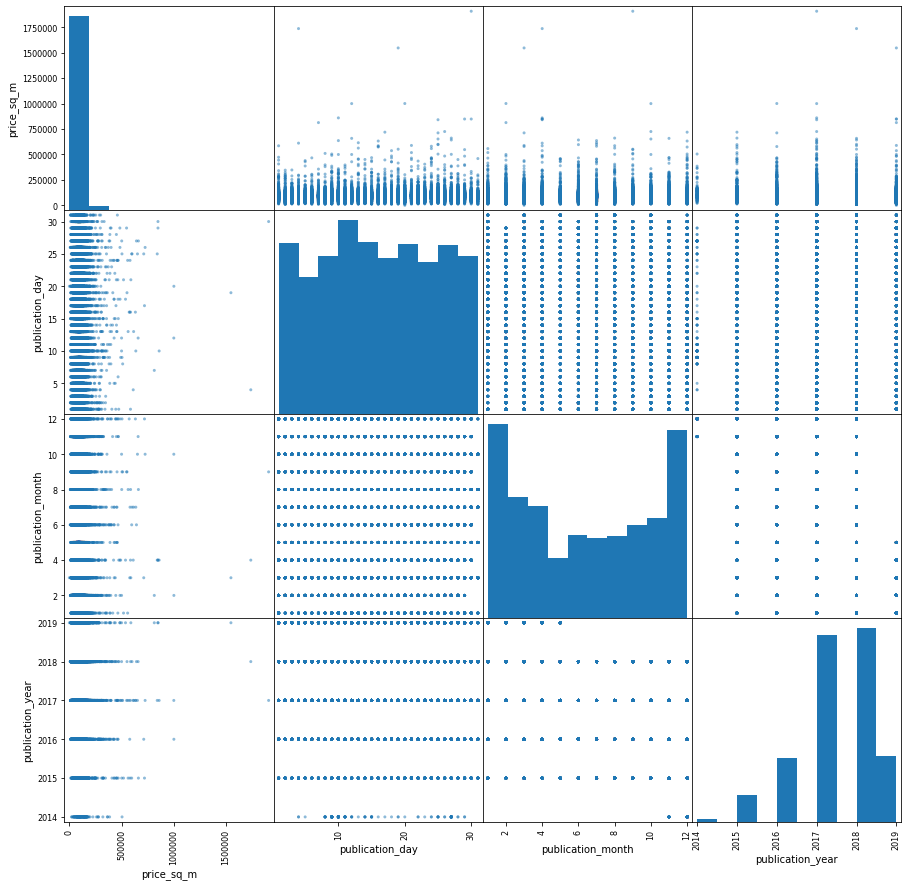

In [17]:
#Также изучите зависимость от даты размещения: дня недели, месяца и года.
price_from_date = df[['price_sq_m','publication_day', 'publication_month','publication_year']]
pd.plotting.scatter_matrix(price_from_date, figsize=(15, 15)) 

**Вывод 4.6** : Подобно шагу 4.3, рассмотрим отношение цены к дням, месяцам и годам.
1. Из гистограммы видно, что цены повысились, начиная с 2014 года. Самая высокая цена была зафиксирована в 2017 году, и общий разброс цен в этом году расположен на значениях относительно выше остальных. Возможно, этот скачок обусловлен кризисом в 2015-16 годах, но могут быть и другие причины.
2. Что касается дня и месяца, здесь разбросы сконцентрированы чуть более равномерно, чем в "year", что означает, что цена не сильно зависит от времени года и числа месяца

In [18]:
# населённые пункты самой высокой и низкой стоимостью жилья
locations_price = df.pivot_table(index='lemmatized_locality', values='price_sq_m', aggfunc='max')
highest_prices_loc = locations_price['price_sq_m'].nlargest(10)
print(highest_prices_loc)

lemmatized_locality
санкт-петербург    1907500
всеволожск          642444
зеленогорск         323943
пушкин              256521
петергоф            228392
неизвестно          197752
сестрорецк          182688
репино              175000
лисий нос           169883
кудрово             162025
Name: price_sq_m, dtype: int64


**Вывод 4.7** : Благодаря столбцу с лемматизированными локациями, были явлены 10 населенных пунктов с самыми дорогими жилыми помещениями. На первом месте- Санкт-Петербург, цена на кв. метр в котором отличается от минимального значения в этом списке (Кудрово) более чем в 11 раз.

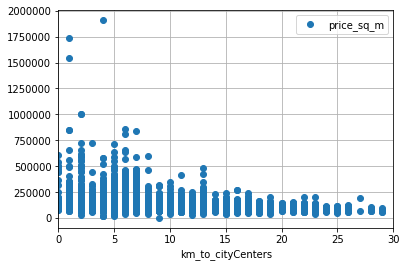

In [19]:
#kак цена зависит от удалённости от центра
df['km_to_cityCenters'] = (df['cityCenters_nearest'] / 1000).round(0) #конвертация растояния до центра города из метров в километры
spb_slice = df.query('lemmatized_locality == "санкт-петербург"')

spb_slice.plot(x='km_to_cityCenters', y='price_sq_m', style='o', xlim=(0, 30), grid=True) 

**Вывод 4.8** : На этом графике, который фокусируется на срезе по городу Санкт-Петербург (с самыми дорогими жилыми помезениями), четко видно, что чем ближе жилое помещение к центру (ближе к 0), тем выше цены на жилье.

         price_sq_m
count  2.369900e+04
mean   9.987371e+04
std    5.041842e+04
min    1.110000e+02
25%    7.698500e+04
50%    9.545400e+04
75%    1.148640e+05
max    1.907500e+06

            price_sq_m
price_sq_m         1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5c32fd850>,
      dtype=object)

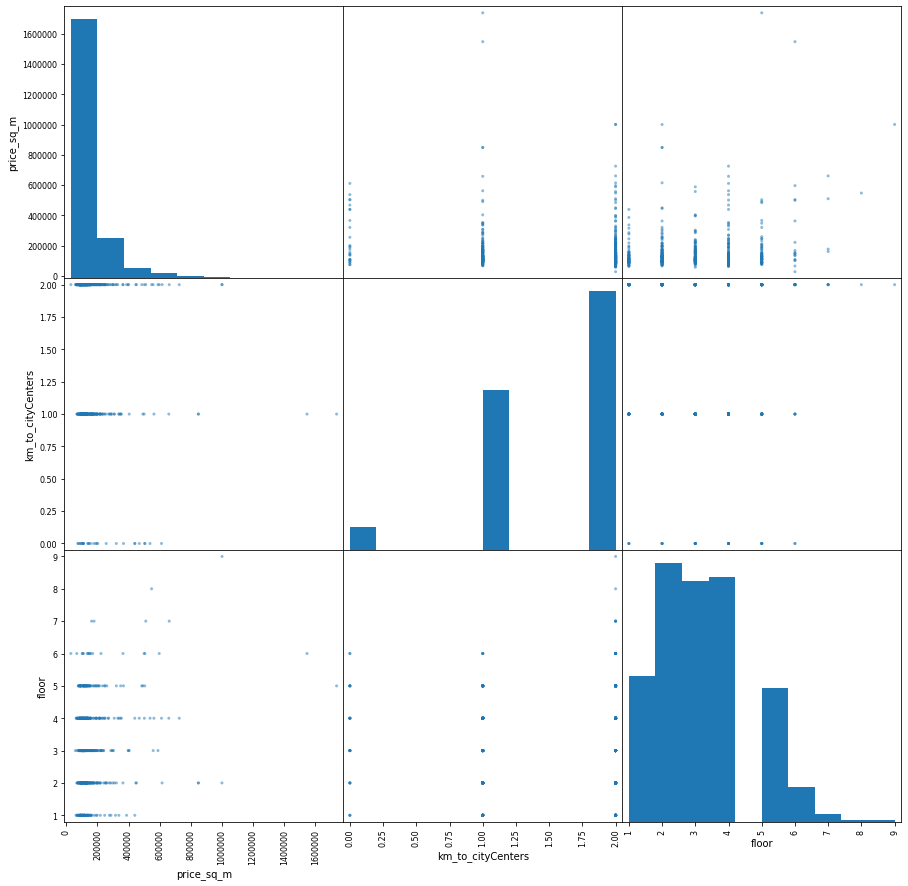

In [20]:
#Анализ квартир в центре города (Санкт-петербург)
spb_cityCenter = spb_slice.query('km_to_cityCenters <= 2')
print(df[['price_sq_m','total_area', 'rooms','ceiling_height']].describe())
print()
print(df[['price_sq_m','total_area', 'rooms','ceiling_height']].corr())

housing_center = spb_cityCenter[['price_sq_m','rooms','km_to_cityCenters','floor','first_day_exposition']]

pd.plotting.scatter_matrix(housing_center, figsize=(15, 15))

Из таблицы корреляции переменных выше видно, что самая сильная корреляция - корреляция между кол-вом комнат и площадью квартиры (логичный вывод). Корреляция по всем остальным переменным позитивная, но слабая, что означает, что если один из параметров увеличится, другой тоже увеличится, но не сильно. Как и при прошлой таблици корреляции, это значает, что возможно есть какие-то другие, более значимые факторы, которые у нас отсутствуют.

**Вывод 4.9** : Аналогично с шагом 4.3 проанализируем отношение цены к этажу, растоянию от центра и кол-ву комнат, но в этот раз сфокусируемся на Санкт-Петербурге. 
1) Отношение цены к этажу: Наибольшее количество выставленных на продажу квартира находятся на 1-5 этажах. Однако, вопреки предыдущему анализу в шаге 4.5, самая высокая цена зафиксирована у 5 этажа. Является ли 5й этаж последним в этом дома - неизвестно.

2) В данном анализе я предположила, что центром можно считать все квартиры расположенные на растоянии 0-2 км от условного "центра города". Как видно на гистограмме, непосредственно в центре Петеррбурга довольно мало объявлений. А самая высокая цена зафиксирована у помещений на расстоянии примерно 1 км от центра.

3) Аналогично, по гистограмме видно, что самая большая цена зафиксирована у помещения с 3 комнатами. А также, наибольшее кол-во выставленных на продажу жилых площадей имеют 2-5 комнат.

## Общий вывод

Разобъём итоги на несколько этапов:
Шаг 1: Проведена первичная оценка имеющихся данных, выявлены пропуски, ошибки, намечен план дальнейших действий по предобработке данных
Шаг 2: Обработан каждый из 22х столбцов в таблице, пропуски заполнены соответствующими значениями, логика заполнения пропусков зафиксирована (в выводе под заданием). По окончании предобработки данных, все пропуски заполнены, столбец 'locality_area' был лемматизирован и преобразован в новый столбец для удобства поиска по данным и с целью исправить имеющиеся ошибки, возникшие при вводе/хранении данных
Шаг 3: Проведены необходимые расчеты и созданы соответствующие столбцы в общем датафрейме. Дополнительно был создан столбец 'last_price_in_mln', который отражал цену помещения в миллионах вместо единиц рублей.
Шаг 4. Проведен исследовательский анализ данных, построены многочисленные графики, гистограммы и сводные таблицы, с целью исследовать данные с каждой стороны

**ИТОГ:** Изначально поставленной задачей было установить параметры, которые бы помогли определять рыночную стоимость объектов недвижимости, чтобы она отслеживать аномалии и мошенническую деятельность. После тщательного анализа данных было выявлено, что самые дорогие квартиры находятся в Санкт-петербурге, в центре города, с кол-вом комнат 2-5, на первых этажах дома, которые были выставлены на продажу не дольше 2х лет. Примерно тот же тренд поддерживается и для других населенных пунктов.

Среди аномалий было выявлено следующее: 

1) Большое количество пропусков в данных, которые описывают качества жилого помещения (растояние от центра, кол-во комнат, площадь помещения, этаж итд) и неравномерное их распределение (много выбросов)

2) Были обнаружены жилые помещения, которые были выставлены на продажу более 3х лет. Также есть немалое количество квартир, которые продавались за срок меньше недели. Причина - неизвестна.

**Рекоммендации:**
1) Выяснить причину наличия пропусков и: а) заполнить их самостоятельно; б) потребовать самих продавцов заполнить отсутсвтующие данные, особенно связанные с описанием самого продаваемого объекта
2) Удалять из базы данных все объявления, которые не закрываются более 2х лет.
3) Выяснить причину "слишком быстрого" закрытия сделки на квартиры, если это возможно, и внести это в базу данных